In [1]:
#librarties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import dataset
data = pd.read_csv("results.csv")
data.head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False


### 1) **What is the impact hosting a major tournament helps a country's chances in winning the most number of matches within the said tournament?**

In [3]:
means = data[['home_score','away_score']].mean()
print("Home score: ",means[0],"\nAway score: ",means[1])

Home score:  1.743690889216292 
Away score:  1.186540563661423


Looking at the mean values, we can see that the home team has scored more than the away team on average. This is an evidence to say that the country who is hosting the tournament have ahigher chance of successful in the said tournament.

This can be further aided by the following graphs

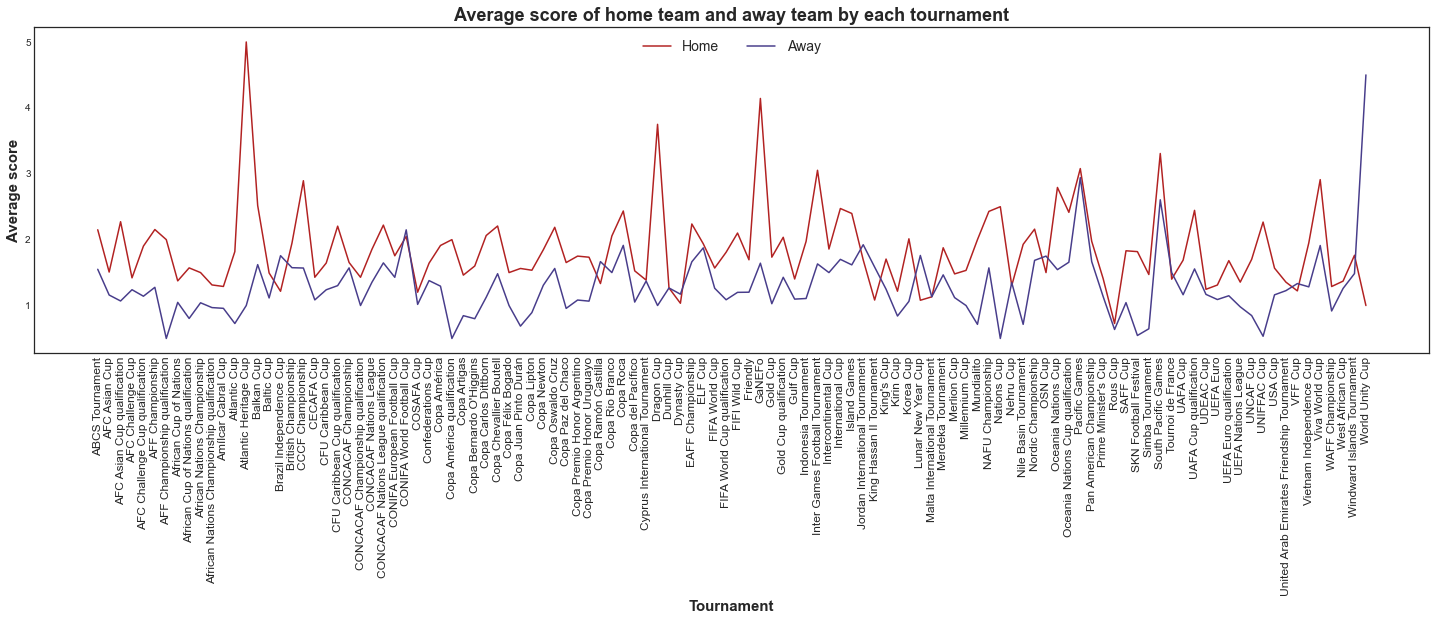

In [4]:
avg_score = data.groupby("tournament")["home_score","away_score"].agg("mean")

plt.figure(figsize=(25,6))
plt.style.use('seaborn-white')
plt.plot(avg_score.home_score, color="firebrick", label = "Home")
plt.plot(avg_score.away_score, color="darkslateblue", label = "Away")
plt.xticks(fontsize=12, rotation=90)
plt.xlabel("Tournament",size=15, fontweight='bold')
plt.ylabel("Average score",size=15, fontweight='bold')
plt.title("Average score of home team and away team by each tournament",size=18,fontweight='bold')
leg=plt.legend(loc='upper center', fontsize=14, ncol=2)
plt.show()

The above lineplots represents the average scores of home team and away team in all times in each tournament. Regardless of the tournament, almost in all of them, the home team has scored more than the away team. This indicate that the home team has a more chance in winning most number of matches within a tournament.

The following graph exhibits the same figure, but only for the major 24 countries in terms of the number of matches played. This graph also directs us the same conclusions. 

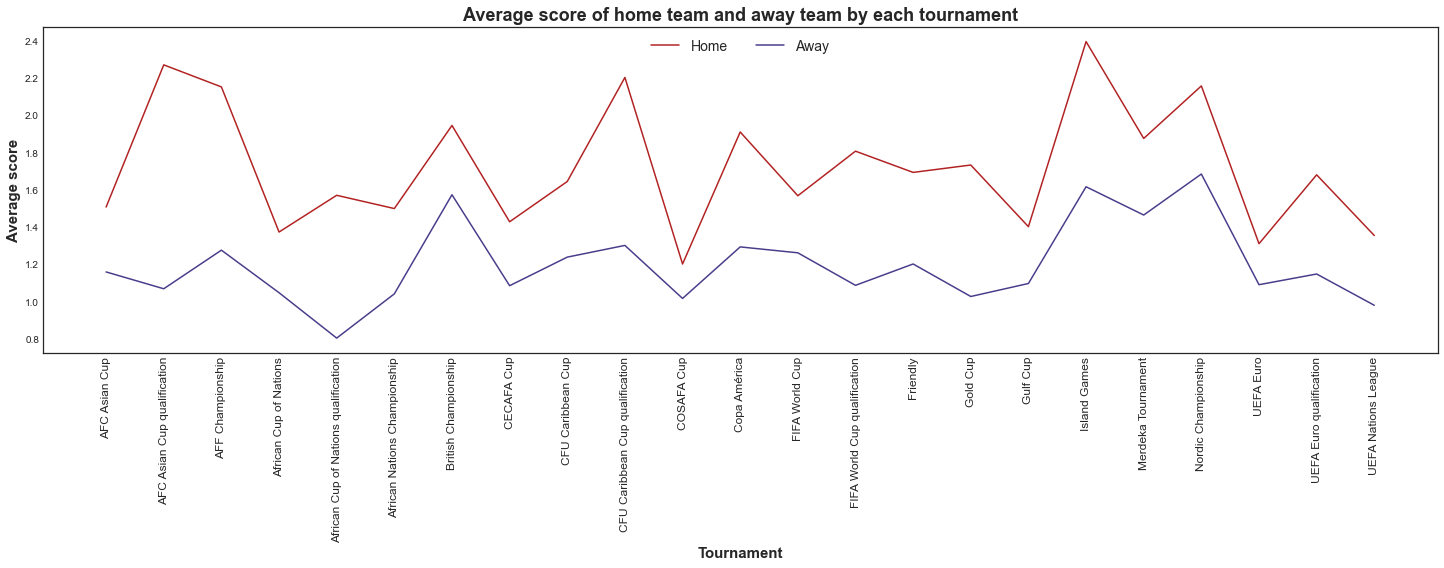

In [5]:
tournaments = pd.DataFrame(data.groupby("tournament")["date"].agg("count")).reset_index()
tournaments.columns = ["tournament","number of matches"]
data = data.merge(tournaments, how='outer', left_on="tournament", right_on = "tournament")
major_tournaments = data[data["number of matches"] > 250 ]
avg_score = major_tournaments.groupby("tournament")["home_score","away_score"].agg("mean")

plt.figure(figsize=(25,6))
plt.style.use('seaborn-white')
plt.plot(avg_score.home_score, color="firebrick", label = "Home")
plt.plot(avg_score.away_score, color="darkslateblue", label = "Away")
plt.xticks(fontsize=12, rotation=90)
plt.xlabel("Tournament",size=15, fontweight='bold')
plt.ylabel("Average score",size=15, fontweight='bold')
plt.title("Average score of home team and away team by each tournament",size=18,fontweight='bold')
leg=plt.legend(loc='upper center', fontsize=14, ncol=2)
plt.show()

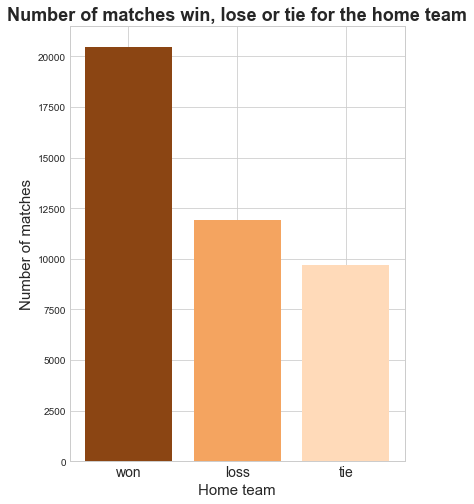

In [6]:
def country_won(row):
    if row['home_score']-row['away_score'] > 0:
        val = "won"
    elif row['home_score']-row['away_score'] < 0:
        val = "loss"
    else:
        val = "tie"
    return val

data['home_win'] = data.apply(country_won, axis=1)
home = pd.DataFrame(data.home_win.value_counts()).reset_index()
home.columns = ["won","number_of_matches"]

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6,8))
#ax = fig.add_axes([0,0,1,1])
plt.bar(home.won,home.number_of_matches, color=['saddlebrown', 'sandybrown', 'peachpuff'])
plt.xticks(fontsize=14)
plt.xlabel("Home team",size=15)
plt.ylabel("Home team",size=15)
plt.ylabel("Number of matches",size=15)
plt.title("Number of matches win, lose or tie for the home team",size=18,fontweight='bold')
plt.show()

The graph upon shows the number of wins, losses and ties recorded by the hometeam in all times. The graph indicates that the number of wins of the home team greatly exceeds the number of losses or ties. This also confirms the possitive effect of being the host country in a tournament towards the success in that tournament.

### 2) **What is the most successful(number of matches played against number of wins) team of all time and is there a specific period(era) that was dominated by teams?**


A widely used ranking statisitc to compare teams or individuals in sports is  ***winning percentage***. The winning percentage refers to the fraction of games or matches a team or individual has won, defined as wins divided by the total number of matches played. Here, a draw is considered as a $1\over2$ win.


<center>${\displaystyle {\text{winning percentage}}={{\text{wins}}+0.5\cdot {\text{ties}} \over {\text{total games}}}\cdot 100\%}$

In [8]:
def country_won(row):
    if row['home_score']-row['away_score'] > 0:
        val = row['home_team']
    elif row['home_score']-row['away_score'] < 0:
        val = row['away_team']
    else:
        val = "None"
    return val

data['country_won'] = data.apply(country_won, axis=1)

In [9]:
#summarizing data by country
##total matches played
home_team = pd.DataFrame(data.home_team.value_counts())
away_team = pd.DataFrame(data.away_team.value_counts())
teams = home_team.merge(away_team, how='outer', left_index=True, right_index=True).fillna(0)
teams["matches"] = teams["home_team"]+teams["away_team"]

##total matches won
teams["wins"] = data.country_won.value_counts()
teams = teams.fillna(0)

##total draws
draw_matches = data[data.home_score == data.away_score]
home_draw = pd.DataFrame(draw_matches.home_team.value_counts())
away_draw = pd.DataFrame(draw_matches.away_team.value_counts())
draw = home_draw.merge(away_draw, how='outer', left_index=True, right_index=True).fillna(0)
draw["ties"] = draw.home_team + draw.away_team
teams["ties"] = draw["ties"]
teams = teams.fillna(0)

#calculate winning percentage
teams["winning_percentage"]  = ((teams["wins"] + 0.5*teams["ties"])/teams["matches"])*100

In [10]:
#Top 5 countries with highest winning percentage
teams.sort_values(by = "winning_percentage", ascending = False)[:5]

,home_team,away_team,matches,wins,ties,winning_percentage
Surrey,0.0,1.0,1.0,1.0,0.0,100.000000
Asturias,0.0,1.0,1.0,1.0,0.0,100.000000
Yorkshire,5.0,2.0,7.0,5.0,1.0,78.571429
Andalusia,12.0,1.0,13.0,8.0,4.0,76.923077
Padania,28.0,15.0,43.0,29.0,8.0,76.744186


According to the results, the teams ***Surrey*** and ***Asturias*** has the highest winning percentage. However, this result cannot be considered reliable due to lower number of matches played by the two teams.

This can be further explored through the following graphs

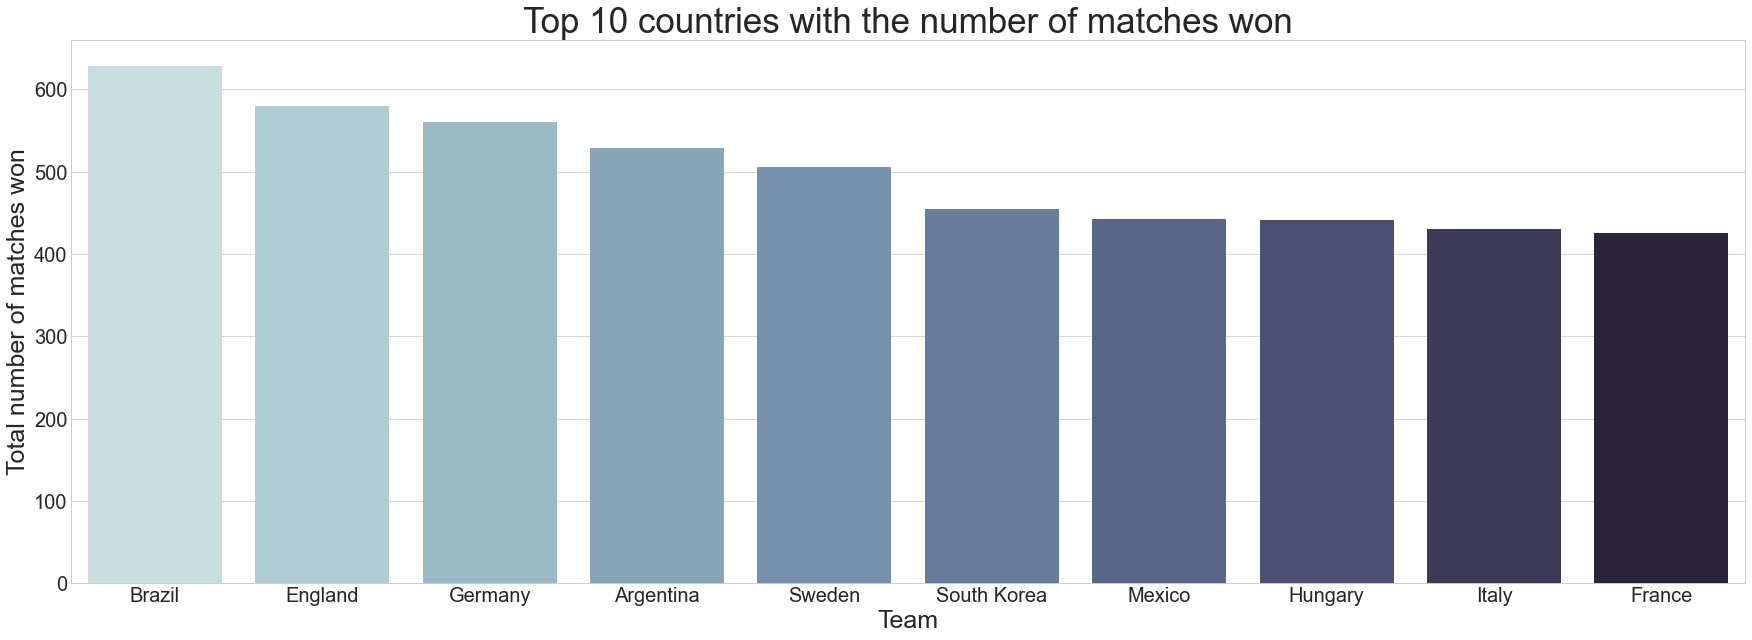

In [11]:
fig=plt.figure(figsize = (30,10))
plt.style.use('seaborn-whitegrid')
plt_data = teams.sort_values(by = "wins", ascending = False).head(10)
fig = sns.barplot(x=plt_data.index, y="wins", data=plt_data, palette="ch:start=.2,rot=-.3")
fig.set_xticklabels(labels = plt_data.index,  fontsize =20)
fig.set_yticklabels([i for i in range(0,701,100)],fontsize=20)
fig.set_xlabel('Team', size=25),
fig.set_ylabel('Total number of matches won', size=25)
fig.set_title("Top 10 countries with the number of matches won", size = 35)

plt.show()

Looking at the above graph, we can see that the matches who has won most number matches are quite different from the results we got for the winning percentage.

To overcome this, a treshold can be use to filter out the teams who has not played a considerable amount of matches. Following table shows the teams with highest percentage value after setting the threshold to the ***average matches played by a team***.

In [12]:
#Top 5 countries with highest winning percentage, threshold = average matches per team
teams[teams.matches >= np.mean(teams.matches)].sort_values(by = "winning_percentage", ascending = False)[:5]

,home_team,away_team,matches,wins,ties,winning_percentage
Brazil,570.0,415.0,985.0,629.0,199.0,73.959391
Spain,364.0,341.0,705.0,411.0,163.0,69.858156
England,505.0,515.0,1020.0,580.0,243.0,68.774510
Germany,513.0,448.0,961.0,560.0,198.0,68.574402
Iran,281.0,221.0,502.0,275.0,128.0,67.529880


Accordingly ***Brazil*** can be considered as the most successful team in the world throughout the Football history. Rest of the top countries are,
- Spain
- England
- Germany
- Iran

In order to see if there are spefic era that the teams have dominate the field, we can use the following graph. The five countries with highest winning percentage values were only considered in when plotting the graph to reduce the complexity.

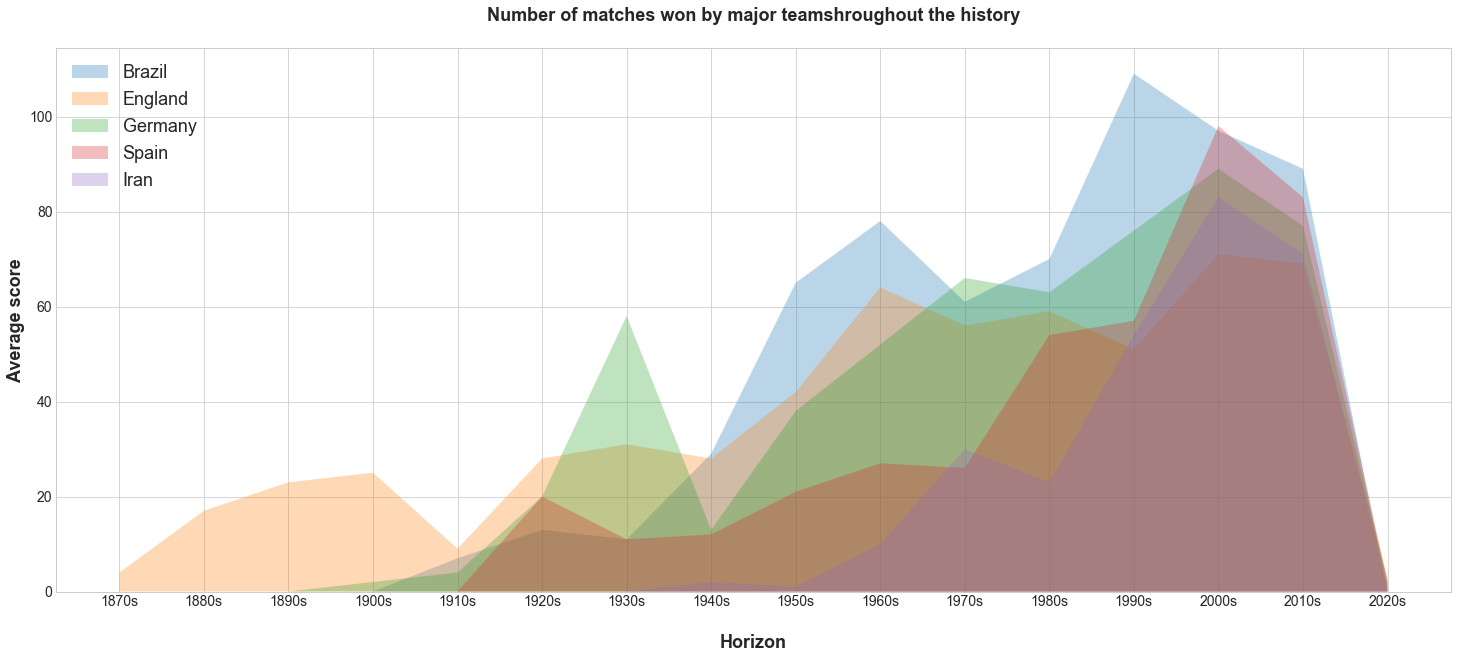

In [13]:
def won(row, team):
    if row['country_won']== team:
        val = 1
    else:
        val = 0
    return val

#derive year from date
data["year"] = data['date'].str.split('-').str[0]

#decade column
bins = [i for i in range(1870,2031,10)]
labels=[str(i)+"s" for i in range(1870,2021,10)]
data["decade"] = pd.cut(data.year.astype(int),bins=bins,labels=labels)

wins = pd.DataFrame(data.groupby(["decade","country_won"])["country_won"].agg("count")).rename(columns = {"country_won": "matches"}).reset_index()

plt.figure(figsize=(25,10))
plt.style.use('seaborn-whitegrid')
plt.stackplot(wins[wins.country_won == "Brazil"].decade, wins[wins.country_won == "Brazil"].matches, alpha=0.3, labels = ["Brazil"])
plt.stackplot(wins[wins.country_won == "England"].decade, wins[wins.country_won == "England"].matches,alpha = 0.3, labels = ["England"])
plt.stackplot(wins[wins.country_won == "Germany"].decade, wins[wins.country_won == "Germany"].matches, alpha = 0.3, labels = ["Germany"])
plt.stackplot(wins[wins.country_won == "Spain"].decade, wins[wins.country_won == "Spain"].matches, alpha = 0.3, labels = ["Spain"])
plt.stackplot(wins[wins.country_won == "Iran"].decade, wins[wins.country_won == "Iran"].matches, alpha = 0.3, labels = ["Iran"])
plt.ylabel("Average score",size=18, fontweight='bold')
plt.xlabel("\nHorizon",size=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.title("Number of matches won by major teamshroughout the history\n",size=18,fontweight='bold')
leg=plt.legend(loc='upper left', fontsize=18, ncol=1)
plt.show()

This graph exihibits the total number of matches won by the teams Brazil, England, Germany, Spain and Iran in all times. 

According to the graph, England has been the dominant country in the field since 1870s to early 19th Century. It is also noticable that most of the countries have started playing in international events by the beginning of 1900s. However, after 1920s Germany has shown a significant improvement in their performance surpassing all the other teams till the end 1930s. The team has withdrawed themselfes from the fields with the beginning of the second world war. Interestngly, after 1940s, Brazil has been dominating the field repeatedly till 2000s, eventhough there is a slight setback in the 1970 decade. After 2000, all five country are showing a equal performance and therefore, we cannot see a noteworthy dominance by a single country.  

In [14]:
def team_summary(team):
    plt.style.use('seaborn-whitegrid')
    home = data[(data.home_team == str(team))]
    away = data[(data.away_team == str(team))]
    team_ = (pd.concat([home, away], ignore_index=True))[["decade","year","country_won"]]
    team_['won'] = team_.apply(lambda x: won(x, team = team), axis=1)
    team_["matches"] = 1
    team_ = (team_.groupby("decade")[["won","matches"]].agg("sum")).reset_index()[4:-1]
    fig = plt.figure(figsize=(20,10))
    plt.stackplot(team_["decade"], team_["matches"], alpha=0.5, labels = ["total number of matches played"], color = "sandybrown")
    plt.stackplot(team_["decade"], team_["won"], alpha=0.5, labels = ["number of matches won"], color = "peru") 
    plt.plot(team_["decade"], team_["matches"]/2, alpha=0.5, color='red', linestyle='dashed',label='50% of the total matches')
    fig.suptitle("Number of matches played and won by "+str(team)+ " over decades", size = 18)
    plt.xlabel('Decades', size = 15)
    plt.ylabel('Number of matches', size = 15)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    fig.legend(fontsize = 14, loc = "lower center", ncol = 3)
    plt.show()

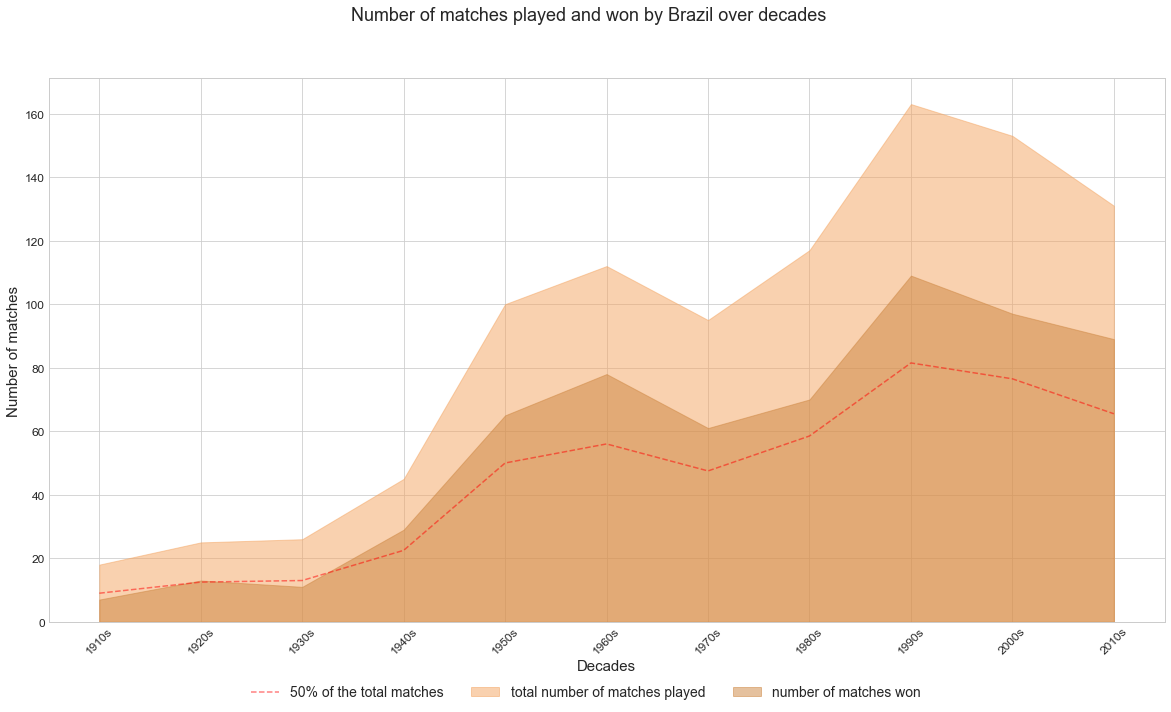

In [15]:
team_summary("Brazil")

Brazil has won more than half of the matches they played in all times. This indicates that the Brazil has been one of the most significant team throughout the history.

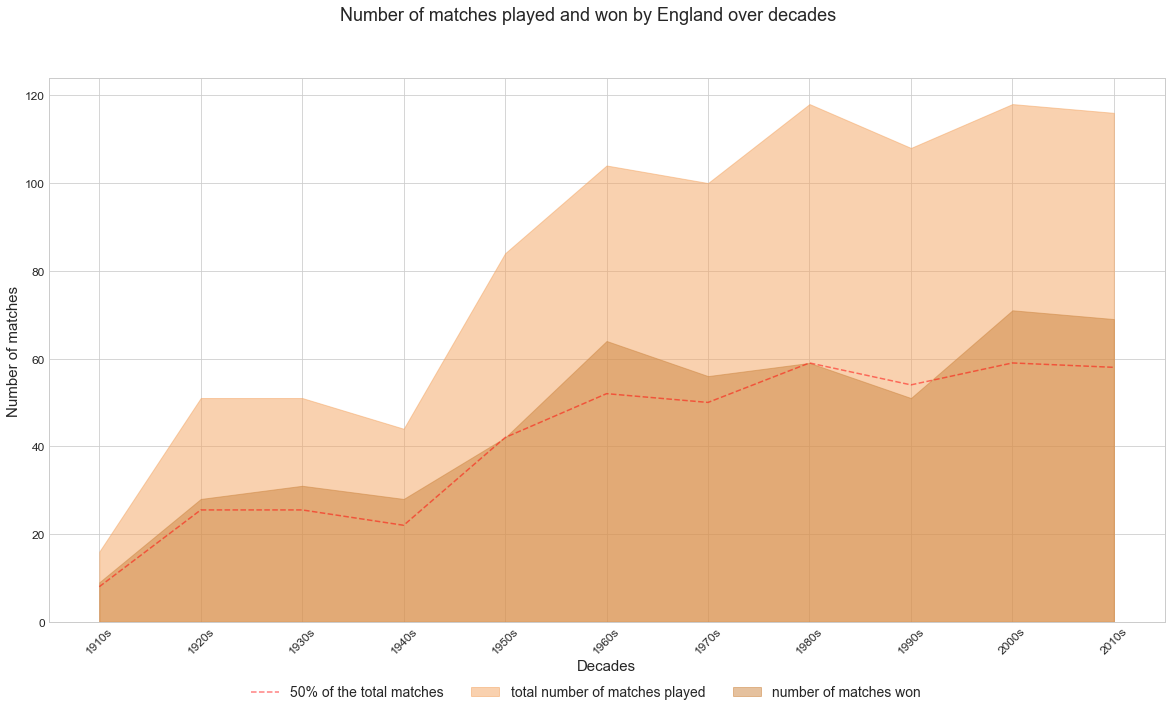

In [16]:
team_summary("England")

Although England has shown a good performance, it has changed time to time. However, after 1990's the team has won more than half of the matches they played. which makes them a top team in the world.

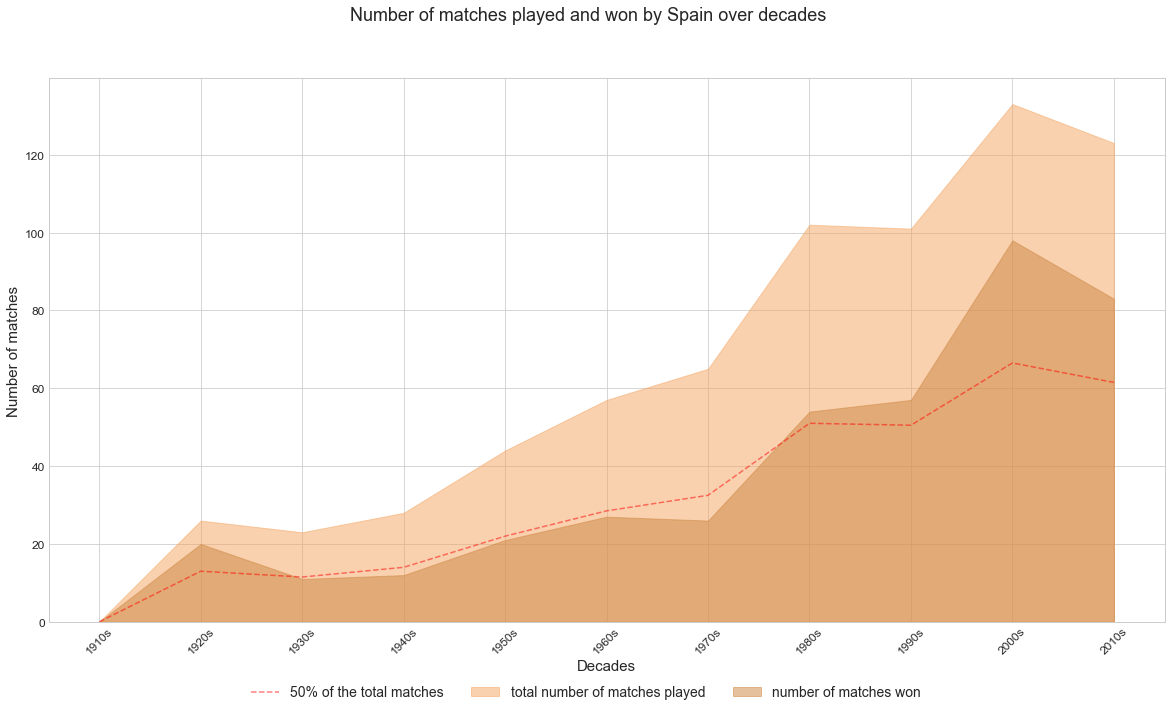

In [17]:
team_summary("Spain")

Sapin has also shown a significant performance after 1980's. In early 2000's they have been one of the best teams as they have won almost 75% matches they have played.

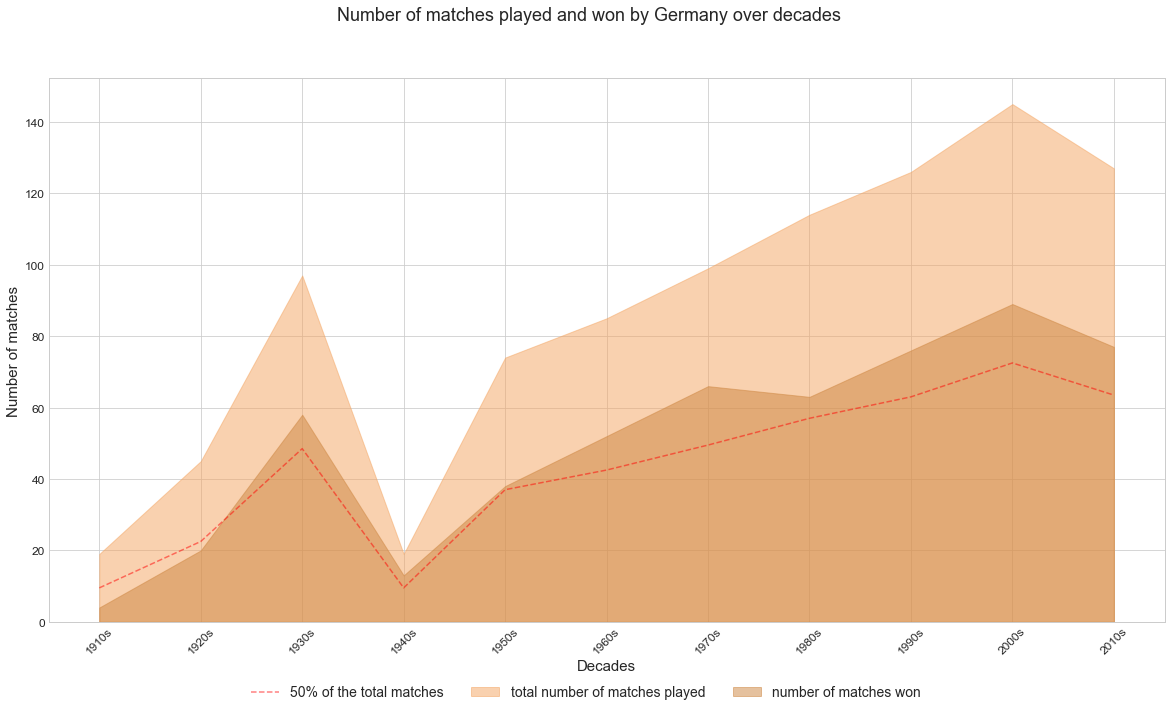

In [18]:
team_summary("Germany")

Germany has participated in very few number of matches in 1940's compared to the other time periods. This must be due to the second world war. However after 1950's Germenay has increasingly improved their performance and now they are one of the top teams in the world.

### 3)As per the guidelines of FIFA, the next world cup is to be hosted in Qatar in 2022.

#### a) Define a ML algorithm to find the team that would be most successful(highest number of wins) in this event.

As indicate in the question, the algorithm is supposed to predict the number of wins by each country in the upcoming FIFa World Cup.Therefore, a regression analysis should conducted. First, a dataset should be created to predict the number of matches won by each team in the said FIFA World Cup tournamnet.

According to the literature in this domain, following variables are said to have an impact towards the success of the football teams in the field.
1. ***hosted:***   Whether the team is hosting the current tournament
3. ***rank:***   Current rank of the team according the FIFA world rankings
4. ***temperature:***   Average temperature of the coutnry
5. ***GDP:***   Current GDP of the country

Hence, the new dataset is created by integrating above features into the existing dataset.

In [58]:
def country_won(row):
    if row['home_score']-row['away_score'] > 0:
        val = row['home_team']
    elif row['home_score']-row['away_score'] < 0:
        val = row['away_team']
    else:
        val = "None"
    return val

data['country_won'] = data.apply(country_won, axis=1)
data["year"] = data['date'].str.split('-').str[0]
data["year"] = pd.to_numeric(data["year"])

Here, only the data of FIFA World Cup are considered for the analysis.

In [20]:
#filter the data to get only FIFA World Cup data
data = data[data.tournament == "FIFA World Cup"]
data.shape

(900, 14)

In [21]:
#deriving the starting year of each country
start_year_h = pd.DataFrame(data.groupby("home_team")["year"].agg("min")).reset_index().rename(columns = {"home_team":"team"})
start_year_a = pd.DataFrame(data.groupby("away_team")["year"].agg("min")).reset_index().rename(columns = {"away_team":"team"})
start_year = pd.merge(start_year_h,start_year_a, how='outer', left_on=["team","year"], right_on = ["team","year"])
start_year.columns = ["team","start_year"]

In [22]:
##create the dataset, teams
#total number of matches played
home_team = pd.DataFrame(data[["home_team","year"]].value_counts())
away_team = pd.DataFrame(data[["away_team","year"]].value_counts())
teams = home_team.merge(away_team, how='outer', left_index=True, right_on = ["away_team","year"]).fillna(0)
teams["matches"] = teams["0_x"]+teams["0_y"]
teams = teams.fillna(0)

#number of matches tied
draw_matches = data[data.home_score == data.away_score]
home_draw = pd.DataFrame(draw_matches[["home_team","year"]].value_counts())
away_draw = pd.DataFrame(draw_matches[["away_team","year"]].value_counts())
draw = home_draw.merge(away_draw, how='outer', left_index=True, right_on=["away_team","year"]).fillna(0)
draw["ties"] = draw["0_x"] + draw["0_y"]
teams["ties"] = draw["ties"]
teams = teams.fillna(0)

#number of matches won
wins =pd.DataFrame(data[["country_won","year"]].value_counts())
teams = teams.merge(wins, how='outer', left_on=["away_team","year"], right_index = True).fillna(0).reset_index()

teams = teams[teams.away_team != "None"]
teams = teams.drop(['0_x','0_y'], axis =1)
teams.columns = ["team","year", "matches", "ties","wins" ]

#calculate winning percentage
teams["winning_percentage"]  = ((teams["wins"] + 0.5*teams["ties"])/teams["matches"])*100
teams.head(3)

,team,year,matches,ties,wins,winning_percentage
0,Germany,2006,7.0,1.0,5.0,78.571429
1,Italy,1990,7.0,1.0,6.0,92.857143
2,South Korea,2002,7.0,2.0,3.0,57.142857


In [24]:
## adding additional variables
#add dummy variable hosted
host_countries = data[["country","year"]].drop_duplicates()
host_countries.columns = ["country_hosted", "year"]
teams = teams.merge(host_countries, how='outer', left_on  = ["team", "year"], right_on = ["country_hosted", "year"])
teams['hosted'] = np.where(teams['team']== teams["country_hosted"], 1, 0)
teams = teams.drop("country_hosted", axis = 1)

#add number_of_years_played attribute
teams = teams.merge(start_year, how='outer', left_on  = ["team"], right_on = ["team"]).dropna()
teams["number_of_years_played"] = teams.year - teams.start_year 

#add country rankings
rankings = pd.read_csv("rankings.csv")
rankings["year"] = rankings["year"]
teams = teams.merge(rankings, how='outer', left_on  = ["team", "year"], right_on = ["country", "year"]).dropna()

#add country temperature
temperature = pd.read_csv("temperature.csv")
teams = teams.merge(temperature, how='outer', left_on  = ["team"], right_on = ["country"]).dropna()

#add country GDP
GDP = pd.read_csv("GDP.csv")
GDP["year"] = GDP["year"]
teams = teams.merge(GDP, how='outer',left_on  = ["team", "year"], right_on = ["country", "year"]).dropna()

First, a histogram is plotted to understand the distribution of the data (response variable, wins).

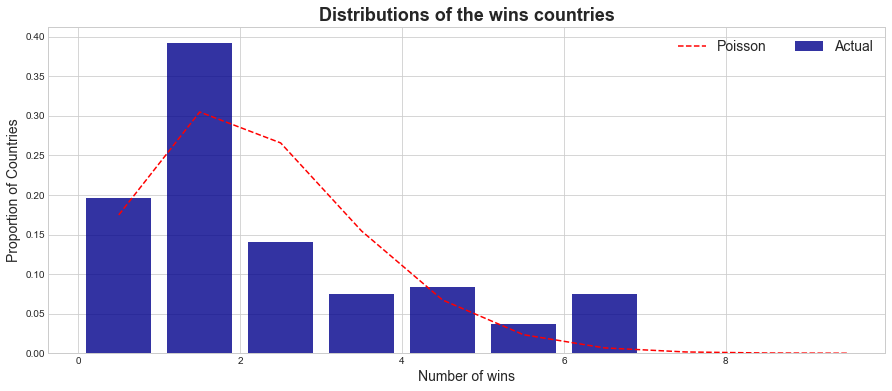

In [25]:
plt.figure(figsize=(15,6))
plt.style.use('seaborn-whitegrid')
plt.hist(teams['wins'].values, range(8), alpha=0.8,density=True, color="darkblue", rwidth = 0.8,label="Actual")
poisson_pred = np.column_stack([[stats.poisson.pmf(k, means[j]) for k in range(10)] for j in range(2)])
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],linestyle='--',label="Poisson", color = 'Red')


plt.xlabel("Number of wins",size=14)
plt.ylabel("Proportion of Countries",size=14)
plt.title("Distributions of the wins countries",size=18,fontweight='bold')
leg=plt.legend(loc='best', fontsize=14, ncol=2)
plt.show()

As shown in the figure, the variable wins, which is number of matches won by each team in each FIFA World Cup tournamanet is following a **Poisson distribution**. Therefore, estimating a **Poisson Regression** model would be more appropriate than a Lnear Rgression. Poisson regression is a generalized linear model form of regression analysis used to model count data. Poisson regression assumes the response variable Y has a Poisson distribution, and assumes the logarithm of its expected value can be modeled by a linear combination of unknown parameters.

In order to make sure of this fact, we can estimate both models and select the model with best performance.

In [60]:
X = teams[["number_of_years_played","hosted","rank","temperature", "GDP"]] #independent variables
y = teams["wins"] #dependent variable

In [27]:
Linear_Regression = LinearRegression() #linear regression
PoissonRegression = CatBoostRegressor(iterations = None, objective='Poisson',eval_metric = "R2", verbose = False ) #poisson distrbution with catboost 

In [28]:
#model fitting
Linear_model = Linear_Regression.fit(X, y) #linear
Poisson_catboost_model = PoissonRegression.fit(X, y) #poisson

In [29]:
#model prediction
predictions_LR = Linear_model.predict(X)
predictions_PR = Poisson_catboost_model.predict(X)

In [30]:
#accuracy scores
print("R-squared value for Linear Regression: ",r2_score(y, [round(x) for x in predictions_LR]), "\nR-squared value for Poisson Regression with CatBoost: ", r2_score(y, [round(x) for x in predictions_PR]))

R-squared value for Linear Regression:  0.283495582690901 
R-squared value for Poisson Regression with CatBoost:  1.0


According to the resulted R squre values by the two models, we can clearly understand that the Poisson regression model is performing much better than the Linear Regression model.
We can graphically illustrate this using predicted vs actual graphs. 

(Note that the predicted values are rounded off as number of wins cannot be floats)

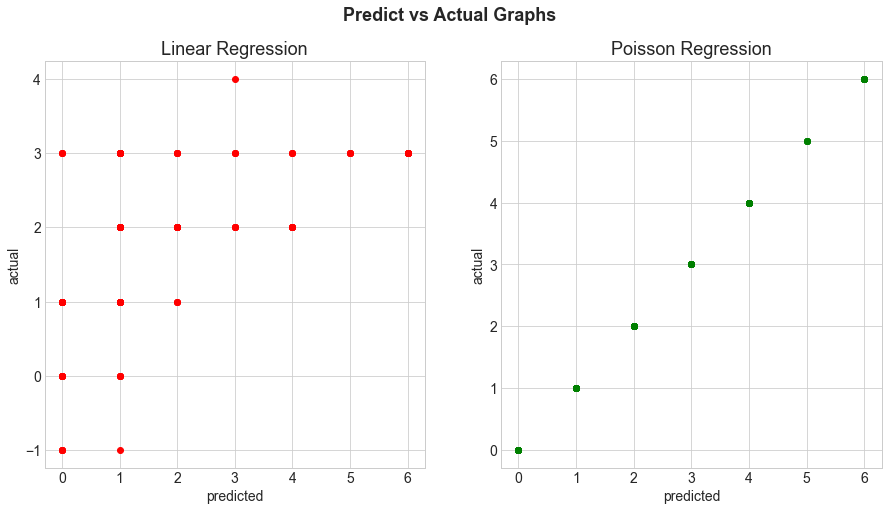

In [31]:
#predicted vs actual graph
fig, axes = plt.subplots(1,2, figsize=(15,7.5))
##linear regression
axes[0].scatter(y, [round(x) for x in predictions_LR], color="r")
axes[0].set_xlabel("predicted", fontsize = 14)
axes[0].set_ylabel("actual", fontsize = 14)
axes[0].tick_params(axis="x", labelsize=14)
axes[0].tick_params(axis="y", labelsize=14)

#poisson regression
axes[1].scatter(y, [round(x) for x in predictions_PR], color="g")
axes[1].set_xlabel("predicted", fontsize = 14)
axes[1].set_ylabel("actual", fontsize = 14)
axes[1].tick_params(axis="x", labelsize=14)
axes[1].tick_params(axis="y", labelsize=14) 

fig.suptitle("Predict vs Actual Graphs", size = 18, fontweight="bold")
axes[0].set_title('Linear Regression', size = 18)
axes[1].set_title('Poisson Regression', size = 18)
plt.show()

As we can see in the graphs, the predictions of the linear regression model are scattered around the plane, while the points in poission regression model is linearly distributed across the diagonal. this further assures the appropriateness of the poisson regression for the existing problem.

We can evaluate this model using 10 Fold cross validation technique. however, as shown below, the test results of each fold seems to have quite different scores. This might be due to the fact that there is only a small number of training data in the model. 

In [32]:
#cross validation
cv_results = cross_validate(PoissonRegression, X, y, cv=10, return_train_score = True)

In [33]:
print("Scores: \n",cv_results["test_score"], "\nMean score: ", np.mean(cv_results["test_score"]))

Scores: 
 [-0.10325822 -0.18622692 -0.53735545 -2.22995884 -0.84788136  0.73151286
 -0.27377879  0.61300872 -0.36327578  0.55001645] 
Mean score:  -0.2647197316935675


We can use a learing curve to identify whether the accuracy increases with the number of training examples. The following graph shows how the test score changes with the number of examples in training set.

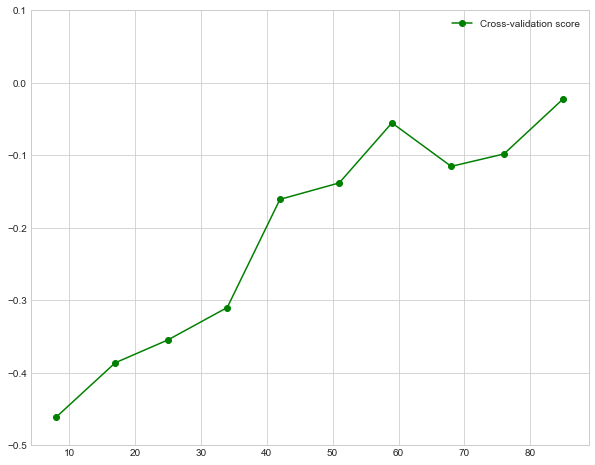

In [65]:
#learnin curve
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(PoissonRegression, X, y, cv=None, n_jobs=None,train_sizes=np.linspace(.1, 1.0, 10),return_times=True, shuffle = True, random_state = 60)
test_scores_mean = np.mean(test_scores, axis=1)
ax = plt.figure(figsize=(10, 8))
plt.style.use('seaborn-whitegrid')
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best")
plt.ylim(-0.5, 0.1)
fig.suptitle("Learning curve", size = 18, fontweight="bold")
plt.show()

As illustrated in the graph, the values are keep increasing with the number of datapoints in the training set. Therefore, it is reasonable to assume that we can get higher scores with an adaquate number of training examples.

Accordingly, the Poisson regression formula for this model can be represented as:


<center>
    
    𝑌 ~ 𝑃𝑜𝑖𝑠𝑠𝑜𝑛(𝜆)

<center>$𝑌 = 𝛽_1{\text{number of years played}}+𝛽_2hosted+𝛽_3rank+𝛽_4temperature+𝛽_5GDP$

Finally, the predictions can be made using the trained poisson regression model.

In [35]:
#form the dataset for prediction
fifa_2022 = {'team':['England', 'Brazil', 'Uruguay', 'France','Germany'],
              'number_of_years_played': [149, 103, 120, 117, 113],
            'hosted':[0, 0, 0, 0, 0],
             'rank': [4, 3, 8, 2, 13],
             'temperature': [9.07,25.51,17.93,11.69,9.63],
             'GDP': [3124650000000, 1491772000000, 55459000000, 2938271000000, 4319286000000]
            }
fifa_2022 = pd.DataFrame(fifa_2022)

In [36]:
#final prediction
pd.DataFrame([round(i) for i in Poisson_catboost_model.predict(fifa_2022.iloc[:,1:])],fifa_2022.team, columns = ["number of wins"])

,number of wins
team,
England,3
Brazil,3
Uruguay,2
France,8
Germany,1


According to the predicted results, **France** team are more likely to be successful in the upcoming FIFA World Cup 2022.

#### b) If the 1st four opponents of England in the said world cup are Brazil, Uruguay, France and Germany define using the above ML algorithm what are the chances of England winning those matches.

To predict the outcomes of these matches, we can use the same algorithm used in the previous problem with few modifications. However, instead of predicting the number of wins, in this problem we should predict the number number of goals (scores) recieved by two teams play in each match.
Then based on the predicted scores, we can decide which teams actually wins the match.

Similar to the previous case, here, we will be using the following variables as the input featres for the regression. 
1. team
2. opponent
4. year
5. hosted
6. team_rank
7. opponent_rank
8. team_temp
9. opponent_temp
10. team_gdp
11. opponent_gdp

The response variable is the number of goals scored by the "team".

However, our final outcome is the team who wins each match.
The formular for this model will as be follows:

<center>
    
    𝑌 ~ 𝑃𝑜𝑖𝑠𝑠𝑜𝑛(𝜆)

<center>$𝑌 = 𝛽_1{\text{hosted}}+𝛽_2{\text{team_rank}}+𝛽_3{\text{opponent_rank}}+𝛽_4{\text{team_temp}}+𝛽_5{\text{opponent_temp}}+𝛽_6{\text{team_gdp}}+𝛽_7{\text{opponent_gdp}}$

In [50]:
#create the dataset
##team, opponents and scores
h_matches = data[["home_team", "away_team", "home_score", "away_score", "year"]]
h_matches.columns = ["team", "opponent", "score", "opponent_score","year"]
h_matches["hosted"] = 1
a_matches = data[["away_team", "home_team", "away_score","home_score","year"]]
a_matches.columns = ["team", "opponent", "score", "opponent_score","year"]
a_matches["hosted"] = 0

matches = pd.concat([h_matches, a_matches]).reset_index(drop = True)
matches.shape

##additional features
##ranking of the two teams
ranks = pd.read_csv("rankings.csv")
ranks["year"] = ranks.year +1
matches = matches.merge(ranks, how = "left", left_on = ["team","year"], right_on = ["country","year"]).dropna()
matches = matches.merge(ranks, how = "left", left_on = ["opponent","year"], right_on = ["country","year"]).dropna()
matches = matches.drop(["country_y","country_x"], axis =1)
matches.columns =["team", "opponent", "score", "opponent_score","year","hosted","team_rank","opponent_rank"]

##temperature of the two countries
temp = pd.read_csv("temperature.csv")
matches = matches.merge(temp, how = "left", left_on = ["team"], right_on = ["country"]).dropna()
matches = matches.merge(temp, how = "left", left_on = ["opponent"], right_on = ["country"]).dropna()
matches = matches.drop(["country_y","country_x"], axis =1)
matches.columns =["team", "opponent", "score", "opponent_score","year","hosted","team_rank","opponent_rank","team_temp", "opponent_temp"]

##GDP of the two countries
GDP = pd.read_csv("GDP.csv")
GDP["year"] = GDP.year + 1
matches = matches.merge(GDP, how = "left", left_on = ["team","year"], right_on = ["country","year"]).dropna()
matches = matches.merge(GDP, how = "left", left_on = ["opponent","year"], right_on = ["country","year"]).dropna()
matches = matches.drop(["country_y","country_x"], axis =1)
matches.columns =["team", "opponent", "score","opponent_score","year","hosted","team_rank","opponent_rank","team_temp", "opponent_temp", "team_gdp", "opponent_gdp"]
matches.head()

#variable win: whether "team" wins or not
def win(row):
    if row['score'] > row['opponent_score']:
        val =1
    else:
        val = 0
    return val
matches['win'] = matches.apply(win, axis=1)
matches.head()

,team,opponent,score,opponent_score,year,hosted,team_rank,opponent_rank,team_temp,opponent_temp,team_gdp,opponent_gdp,win
0,Brazil,Croatia,3,1,2014,1,14.0,9.0,25.51,11.66,2.470000e+12,5.819407e+10,1
1,Chile,Australia,3,1,2014,1,20.0,47.0,8.71,21.94,2.780000e+11,1.580000e+12,1
2,Mexico,Cameroon,1,0,2014,1,18.0,62.0,21.31,24.87,1.270000e+12,3.235735e+10,1
3,Spain,Netherlands,1,5,2014,1,1.0,7.0,13.93,10.40,1.350000e+12,8.770000e+11,0
4,Colombia,Greece,3,0,2014,1,4.0,12.0,24.79,14.24,3.820000e+11,2.380000e+11,1


In [51]:
#spliting the data
matches = matches.sample(frac=1).reset_index(drop=True)
train = matches.iloc[:140,:]
test = matches.iloc[140:,:]

X_train = train[["hosted","team_rank","opponent_rank","team_temp","opponent_temp","team_gdp","opponent_gdp"]]
X_test_team = test[["hosted","team_rank","opponent_rank","team_temp","opponent_temp","team_gdp","opponent_gdp"]]
X_test_opponent = pd.DataFrame()
X_test_opponent[["hosted","team_rank","opponent_rank","team_temp","opponent_temp","team_gdp","opponent_gdp"]] = test[["hosted","opponent_rank","team_rank","opponent_temp","team_temp","opponent_gdp","team_gdp"]]
y_train = train["score"]
y_test = test["score"]

print("X_train: ",X_train.shape,"\nX_test: ",X_test_team.shape,X_test_opponent.shape, "\ny_train: ",y_train.shape,"\ny_test: ",y_test.shape)

X_train:  (140, 7) 
X_test:  (40, 7) (40, 7) 
y_train:  (140,) 
y_test:  (40,)


In [52]:
#model training
model = PoissonRegression.fit(X_train, y_train)

In [53]:
#prediction for evaluation
test["pred_score"] = model.predict(X_test_team)
test["pred_opponent_score"] = model.predict(X_test_opponent)

def win(row):
    if row['pred_score'] > row['pred_opponent_score']:
        val =1
    else:
        val = 0
    return val
test["win_pred"] = test.apply(win, axis=1)

In [54]:
#accuracy score and classification report
print("Accuracy Score: ",accuracy_score(test["win"], test["win_pred"]), "\n\nClassification Report: \n",classification_report(test["win"], test["win_pred"]))

Accuracy Score:  0.8 

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.74      0.81        23
           1       0.71      0.88      0.79        17

    accuracy                           0.80        40
   macro avg       0.80      0.81      0.80        40
weighted avg       0.82      0.80      0.80        40



The model seems to perform well in terms of Accuracy, Precision, Recall, as well as f1-score. Therefore, we can use this algorithm to predict the outcome of each match.

In [68]:
#form the datset for prediction
fifa_2022_t = {"team":["England", "England", "England", "England"],
             "opponent":["Brazil", "Uruguay", "France", "Germany"],
             "hosted":[0, 0, 0, 0],
             "team_rank":[4, 4, 4, 4],
             "opponent_rank":[2, 13, 3, 16],
             "team_temp":[9.07, 9.07, 9.07, 9.07],
             "opponent_temp":[25.51,17.93,11.69,9.63],
             "team_gdp":[3124650000000, 3124650000000, 3124650000000, 3124650000000],
             "opponent_gdp":[ 1491772000000, 55459000000, 2938271000000, 4319286000000]
            }

fifa_2022_o = {"team": ["Brazil", "Uruguay", "France", "Germany"],
             "opponent":["England", "England", "England", "England"],
             "hosted":[0, 0, 0, 0],
             "team_rank":[2, 13, 3, 16],
             "opponent_rank":[4, 4, 4, 4],
             "team_temp":[25.51,17.93,11.69,9.63],
             "opponent_temp":[9.07, 9.07, 9.07, 9.07],
             "team_gdp":[ 1491772000000, 55459000000, 2938271000000, 4319286000000],
             "opponent_gdp":[3124650000000, 3124650000000, 3124650000000, 3124650000000]
            }

fifa_2022_t = pd.DataFrame(fifa_2022_t)
fifa_2022_o = pd.DataFrame(fifa_2022_o)
pred_t = model.predict(fifa_2022_t.iloc[:,2:])
pred_o = model.predict(fifa_2022_o.iloc[:,2:])

results = pd.DataFrame(fifa_2022_t.team)
results["opponent"] = fifa_2022_t.opponent
results["team_score"] = pred_t
results["opponent_score"] = pred_o 

def win(row):
    if row['team_score'] > row['opponent_score']:
        val =row['team']
    else:
        val = row['opponent']
    return val

#final results
results["winner"] = results.apply(win, axis=1)
results

,team,opponent,team_score,opponent_score,winner
0,England,Brazil,3.991302,1.250894,England
1,England,Uruguay,0.465792,0.192240,England
2,England,France,1.045264,0.436170,England
3,England,Germany,0.244890,0.294354,Germany


#### c) If the same four matches above were played in England (basically, imagine the 2022 world cup is hosted in England rather than Qatar) what would be the chances of England winning those matches.

Here, we only need have a slight change in the prediction dataset. Since team England is hosting we need to revise the "hosted" variable accordingly.

In [69]:
fifa_2022_t = {"team":["England", "England", "England", "England"],
             "opponent":["Brazil", "Uruguay", "France", "Germany"],
             "hosted":[1, 1, 1, 1],
             "team_rank":[4, 4, 4, 4],
             "opponent_rank":[2, 13, 3, 16],
             "team_temp":[9.07, 9.07, 9.07, 9.07],
             "opponent_temp":[25.51,17.93,11.69,9.63],
             "team_gdp":[3124650000000, 3124650000000, 3124650000000, 3124650000000],
             "opponent_gdp":[ 1491772000000, 55459000000, 2938271000000, 4319286000000]
            }

fifa_2022_o = {"team": ["Brazil", "Uruguay", "France", "Germany"],
             "opponent":["England", "England", "England", "England"],
             "hosted":[0, 0, 0, 0],
             "team_rank":[2, 13, 3, 16],
             "opponent_rank":[4, 4, 4, 4],
             "team_temp":[25.51,17.93,11.69,9.63],
             "opponent_temp":[9.07, 9.07, 9.07, 9.07],
             "team_gdp":[ 1491772000000, 55459000000, 2938271000000, 4319286000000],
             "opponent_gdp":[3124650000000, 3124650000000, 3124650000000, 3124650000000]
            }

fifa_2022_t = pd.DataFrame(fifa_2022_t)
fifa_2022_o = pd.DataFrame(fifa_2022_o)
pred_t = model.predict(fifa_2022_t.iloc[:,2:])
pred_o = model.predict(fifa_2022_o.iloc[:,2:])

results = pd.DataFrame(fifa_2022_t.team)
results["opponent"] = fifa_2022_t.opponent
results["team_score"] = pred_t
results["opponent_score"] = pred_o 

def win(row):
    if row['team_score'] > row['opponent_score']:
        val =row['team']
    else:
        val = row['opponent']
    return val
results["winner"] = results.apply(win, axis=1)
results

,team,opponent,team_score,opponent_score,winner
0,England,Brazil,1.411826,1.250894,England
1,England,Uruguay,0.136737,0.192240,Uruguay
2,England,France,0.550124,0.436170,England
3,England,Germany,0.224985,0.294354,Germany
